# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

#### Importing required libraraies for Definition of agent

In [2]:
import random
import copy
from collections import namedtuple, deque
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Defining agent actions , switching between different states, learn from sampled data and update the learning curve

In [3]:
class MultiAgent_DDPG():
    """Multi agent that contains the two DDPG agents and shared replay buffer."""

    def __init__(self, action_size=2, seed=0, 
                 num_agents=2,
                 buffer_size=10000,
                 batch_size=256,
                 gamma=0.90,
                 update_frequency=5,
                 start_noise_factor=1.0,
                 decay_noise_factor=1.0,
                 stop_noise_factor=30000):
        """
            action_size : number of actions feasible
            seed : Random seed, generated by random function in python
            num_agents : number of distinct agents
            buffer_size : replay buffer size
            batch_size : mini batch size
            gamma : discount factor
            start_noise_factor : initial noise weighting factor
            decay_noise_factor : noise decay rate
            update_frequency : how often to update the network
            stop_noise_factor : max number of timesteps with noise applied in training
        """

        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.update_frequency = update_frequency
        self.gamma = gamma
        self.num_agents = num_agents
        self.noise_weight = start_noise_factor
        self.decay_noise_factor = decay_noise_factor
        self.t_step = 0
        self.noise_on = True
        self.stop_noise_factor = stop_noise_factor

        # create two agents, each with their own actor and critic
        models = [Actor_Critic_Models(num_agents=num_agents) for _ in range(num_agents)]
        self.agents = [DDPG(i, models[i]) for i in range(num_agents)]
        
        # create shared replay buffer
        self.memory = ReplayMemory(action_size, self.buffer_size, self.batch_size, seed)

    def step(self, all_states, all_actions, all_rewards, all_next_states, all_dones):
        all_states = all_states.reshape(1, -1)  # reshape 2x24 into 1x48 dim vector
        all_next_states = all_next_states.reshape(1, -1)  # reshape 2x24 into 1x48 dim vector
        self.memory.add(all_states, all_actions, all_rewards, all_next_states, all_dones)
        
        # Noise will be turned off if t_stop_noise time steps are cleared
        if self.t_step > self.stop_noise_factor:
            self.noise_on = False
        
        self.t_step = self.t_step + 1     
        # Learning frequency in time steps
        if self.t_step % self.update_frequency == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                # considering a random subset of experiences from memory for learning of agent
                experiences = [self.memory.sample() for _ in range(self.num_agents)]
                self.learn(experiences, self.gamma)

    def act(self, all_states, add_noise=True):
        """Defines how an agent can decide on next action and reaches next state as per current policy"""
        all_actions = []
        for agent, state in zip(self.agents, all_states):
            action = agent.act(state, noise_weight=self.noise_weight, add_noise=self.noise_on)
            self.noise_weight *= self.decay_noise_factor
            all_actions.append(action)
        return np.array(all_actions).reshape(1, -1) # reshape 2x2 into 1x4 dim vector

    def learn(self, experiences, gamma):
        """ Calculating next actions based on actor of each agent"""
        all_next_actions = []
        all_actions = []
        for i, agent in enumerate(self.agents):
            states, _, _, next_states, _ = experiences[i]
            agent_id = torch.tensor([i]).to(device)
            # Deciding on the action and fetching next state via target actor network
            state = states.reshape(-1, 2, 24).index_select(1, agent_id).squeeze(1)
            action = agent.actor_local(state)
            all_actions.append(action)
            # Deciding on the action and fetching next state via target actor network
            next_state = next_states.reshape(-1, 2, 24).index_select(1, agent_id).squeeze(1)
            next_action = agent.actor_target(next_state)
            all_next_actions.append(next_action)
                       
        # Learning by random sample 
        for i, agent in enumerate(self.agents):
            agent.learn(i, experiences[i], gamma, all_next_actions, all_actions)
            
    def save_agents(self):
        # save models for local actor and critic 
        for i, agent in enumerate(self.agents):
            torch.save(agent.actor_local.state_dict(),  f"savepoint_actor_agent_{i}.pth")
            torch.save(agent.critic_local.state_dict(), f"savepoint_critic_agent_{i}.pth")



#### Second Agent DDPG

In [4]:
class DDPG():
    """DDPG agent with own actor and critic."""

    def __init__(self, agent_id, model, action_size=2, seed=0,
                 tau=1e-3,
                 lr_actor=1e-4,
                 lr_critic=1e-3,
                 weight_decay=0.0):
        """
            model: model object
            action_size : dimension of each action
            seed : Random seed
            tau : for soft update of target parameters
            lr_actor : learning rate for actor
            lr_critic : learning rate for critic
            weight_decay : L2 weight decay
        """
        random.seed(seed)
        self.id = agent_id
        self.action_size = action_size
        self.tau = tau
        self.lr_actor = lr_actor
        self.lr_critic = lr_critic
       
        # Build Actor Network
        self.actor_local = model.actor_local
        self.actor_target = model.actor_target
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=lr_actor)
        
        # Build Critic Network
        self.critic_local = model.critic_local
        self.critic_target = model.critic_target
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=lr_critic, weight_decay=weight_decay)
        
        # Set weights for local and target actor, respectively, critic the same
        self.copy_weights(self.actor_target, self.actor_local)
        self.copy_weights(self.critic_target, self.critic_local)
        
        # Noise process
        self.noise = OUNoise(action_size, seed)

    def copy_weights(self, target, source):
        """ copy weights from source to target network (part of initialization)"""
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)
    
    def act(self, state, noise_weight=1.0, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        # calculate action values
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            self.noise_val = self.noise.sample() * noise_weight
            action += self.noise_val
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, agent_id, experiences, gamma, all_next_actions, all_actions):
        """Update policy and value parameters using given batch of experience tuples.
            experiences : tuple of (s, a, r, s', done) tuples
            gamma : discount factor
            all_next_actions : each agent's next_action (as calculated by its actor)
            all_actions : each agent's action (as calculated by its actor)
        """

        states, actions, rewards, next_states, dones = experiences

        # update critic
        # get predicted next-state actions and Q values from target models
        self.critic_optimizer.zero_grad()
        agent_id = torch.tensor([agent_id]).to(device)
        actions_next = torch.cat(all_next_actions, dim=1).to(device)
        with torch.no_grad():
            q_targets_next = self.critic_target(next_states, actions_next)
        # compute Q targets for current states (y_i)
        q_expected = self.critic_local(states, actions)
        # q_targets = reward of this timestep + discount * Q(st+1,at+1) from target network
        q_targets = rewards.index_select(1, agent_id) + (gamma * q_targets_next * (1 - dones.index_select(1, agent_id)))
        # compute critic loss
        critic_loss = F.mse_loss(q_expected, q_targets.detach())
        # minimize loss
        critic_loss.backward()
        self.critic_optimizer.step()

        # update actor
        # compute actor loss
        self.actor_optimizer.zero_grad()
        # detach actions from other agents
        actions_pred = [actions if i == self.id else actions.detach() for i, actions in enumerate(all_actions)]
        actions_pred = torch.cat(actions_pred, dim=1).to(device)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # minimize loss
        actor_loss.backward()
        self.actor_optimizer.step()

        # update target networks
        self.update(self.critic_local, self.critic_target, self.tau)
        self.update(self.actor_local, self.actor_target, self.tau)


    def update(self, local_model, target_model, tau):
        """update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
            local_model : weights will be copied from
            target_model: weights will be copied to
            tau : interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

### Noise handling: Ornstein-Uhlenbeck process, allowing linear transformation of state and other variables

In [5]:
class OUNoise:
    """"Ornstein-Uhlenbeck process, allowing linear transformation of state and other variables"""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        random.seed(seed)
        np.random.seed(seed)
        self.size = size
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.size)
        self.state = x + dx
        return self.state

### Building Replay Memory

In [6]:
class ReplayMemory:
    """Buffer memory to store the learning experiences and utilize the in
       learning better"""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

            action_size : action_size
            buffer_size : maximum size of internal memory
            batch_size :  batch size
            seed : random seed,value generated by random function in python 
            experience: tuple with Q-value consisting of state, action, reward, next state and dones
        """
        random.seed(seed)
        np.random.seed(seed)
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        
    def add(self, state, action, reward, next_state, done):
        """Helps add a new experience values to the memory 
           it appends the values and do not clear the values 
           which helps create a sample of Q value tuples in 
           the memory """
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Selecting a random sample of experiences from replay memory."""
          
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """returns size of memory"""
        return len(self.memory)

#### Actor-Critic Model using Deep Deterministic Policy Gradient approach

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)


class ActorModel(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, input_size, output_size, seed, fc1_units=256, fc2_units=256):
        """Initialize parameters and build actor model.

            input_size :  number of dimensions for input layer
            output_size : number of dimensions for output layer
            seed : random seed
            fc1_units : number of nodes in first hidden layer
            fc2_units : number of nodes in second hidden layer
        """
        super(ActorModel, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(input_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, output_size)
        self.bn = nn.BatchNorm1d(fc1_units)
        self.reset_parameters()

    def reset_parameters(self):
        """Initialize weights with near zero values."""
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor network that maps states to actions."""
        if state.dim() == 1:
            state = torch.unsqueeze(state,0)
        x = F.relu(self.fc1(state))
        x = self.bn(x)
        x = F.relu(self.fc2(x))
        x = F.tanh(self.fc3(x))
        return x


class CriticModel(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, input_size, seed, fc1_units=256, fc2_units=256):
        """Initialize parameters and build model.
            input_size : number of dimensions for input layer
            seed : random seed
            fc1_units : number of nodes in the first hidden layer
            fc2_units : number of nodes in the second hidden layer
        """
        super(CriticModel, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(input_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.reset_parameters()

    def reset_parameters(self):
        """Initialize weights with near zero values."""
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, states, actions):
        """Build a critic network that maps (states, actions) pairs to Q-values."""
        xs = torch.cat((states, actions), dim=1)
        x = F.relu(self.fc1(xs))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class Actor_Critic_Models():
    """
    Create object containing all models required per DDPG agent:
    local and target actor and local and target critic
    """

    def __init__(self, num_agents, state_size=24, action_size=2, seed=0):
        """
            num_agents : number of agents
            state_size : number of state dimensions for a single agent
            action_size : number of action dimensions for a single agent
            seed : random seed
        """
        self.actor_local = ActorModel(state_size, action_size, seed).to(device)
        self.actor_target = ActorModel(state_size, action_size, seed).to(device)
        critic_input_size = (state_size+action_size)*num_agents
        self.critic_local = CriticModel(critic_input_size, seed).to(device)
        self.critic_target = CriticModel(critic_input_size, seed).to(device)


In [8]:
! pip install unityagents

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [9]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [10]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [11]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [12]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.09500000160187483
Total score (averaged over agents) this episode: 0.0950000025331974


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [13]:
%load_ext autoreload
%autoreload 2
import torch
from collections import deque

agent = MultiAgent_DDPG(seed=2, start_noise_factor=0.5, update_frequency=2, gamma=1, stop_noise_factor=30000)
episodes = 6000
max_time = 1000
scores = []
scores_deque = deque(maxlen=100)
scores_avg = []

for i in range(1, episodes+1):
    rewards = []
    env_info = env.reset(train_mode=True)[brain_name]    # reset the environment    
    state = env_info.vector_observations                  # get the current state (for each agent)

    # loop over steps
    for t in range(max_time):
        # select an action
        action = agent.act(state)
        # take action in environment and set parameters to new values
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations
        rewards_vec = env_info.rewards
        done = env_info.local_done
        # update and train agent with returned information
        agent.step(state, action, rewards_vec, next_state, done)
        state = next_state
        rewards.append(rewards_vec)
        if any(done):
            break

    # calculate episode reward as maximum of individually collected rewards of agents
    episode_reward = np.max(np.sum(np.array(rewards),axis=0))
        
    scores.append(episode_reward)             # save most recent score to overall score array
    scores_deque.append(episode_reward)       # save most recent score to running window of 100 last scores
    current_avg_score = np.mean(scores_deque)
    scores_avg.append(current_avg_score)      # save average of last 100 scores to average score array
    
    print('\rEpisode {}\tAverage Score: {:.3f}'.format(i, current_avg_score),end="")
    
    # log average score every 200 episodes
    if i % 200 == 0:
        print('\rEpisode {}\tAverage Score: {:.3f}'.format(i, current_avg_score))
        agent.save_agents()

    # break and report success if environment is solved
    if np.mean(scores_deque)>=.5:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i, np.mean(scores_deque)))
        agent.save_agents()
        break


Episode 200	Average Score: 0.007
Episode 400	Average Score: 0.048
Episode 600	Average Score: 0.033
Episode 800	Average Score: 0.084
Episode 1000	Average Score: 0.086
Episode 1200	Average Score: 0.091
Episode 1400	Average Score: 0.113
Episode 1600	Average Score: 0.112
Episode 1800	Average Score: 0.132
Episode 2000	Average Score: 0.076
Episode 2200	Average Score: 0.116
Episode 2400	Average Score: 0.124
Episode 2600	Average Score: 0.290
Episode 2800	Average Score: 0.153
Episode 2912	Average Score: 0.511
Environment solved in 2912 episodes!	Average Score: 0.511


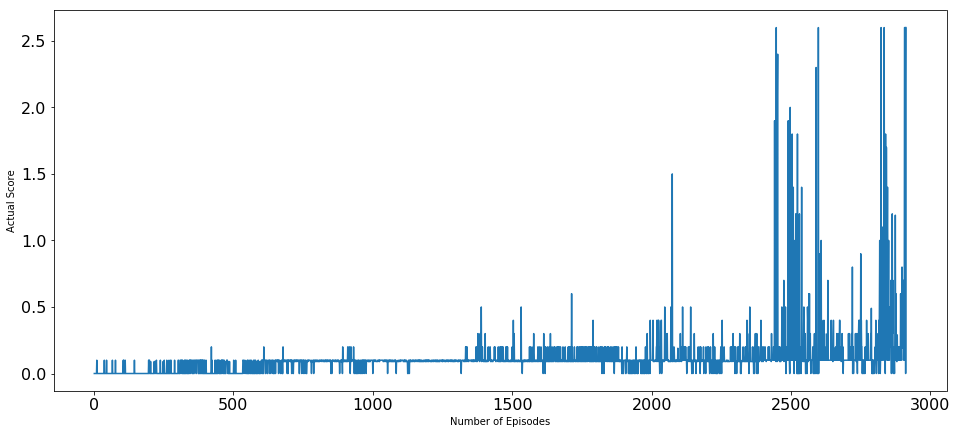

In [20]:
import matplotlib.pyplot as plt
np.random.seed(21)

fig = plt.figure(figsize=(16,7))
ax = fig.add_subplot(111)


# Draw the line plot
plt.plot(np.arange(1, len(scores)+1), scores)

# Define the label of the plots
plt.xlabel('Number of Episodes')
plt.ylabel('Actual Score')

     
# Display the plot
plt.show()

When finished, you can close the environment.

In [21]:
env.close()